# Impor Packages

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

# Import Data

In [ ]:
from google.colab import drive
drive.mount ("/content/MyDrive")

Mounted at /content/MyDrive


In [ ]:
df = pd.read_csv("/content/MyDrive/MyDrive/Online Retail Data (1).csv")
df.head()

,order_id,product_code,product_name,quantity,order_date,price,customer_id
0,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346.0
1,C493411,21539,RETRO SPOTS BUTTER DISH,-1,2010-01-04 09:43:00,4.25,14590.0
2,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,4.50,12346.0
3,493413,21724,PANDA AND BUNNIES STICKER SHEET,1,2010-01-04 09:54:00,0.85,NaN
4,493413,84578,ELEPHANT TOY WITH BLUE T-SHIRT,1,2010-01-04 09:54:00,3.75,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


# Data Cleaning

In [ ]:
#Mengidentifikasi isi kolom tipe data object (apakah order date bisa dijadikan date_time)

for dtype, col in (list(zip(df.dtypes, df.columns))):
  if dtype == "object":
    print(col, dtype)
    print(df[col].unique())

  else :
    print(col, dtype)
    print(df[col].min(), df[col].max())

  print()



order_id object
['493410' 'C493411' '493412' ... '539990' '539991' '539992']

product_code object
['TEST001' '21539' '21724' ... '22721' '22970' '22971']

product_name object
['This is a test product.' 'RETRO SPOTS BUTTER DISH'
 'PANDA AND BUNNIES STICKER SHEET' ... '*USB Office Mirror Ball'
 'MINI LADLE LOVE HEART PINK' 'MINI LADLE LOVE HEART RED']

quantity int64
-9600 10200

order_date object
['2010-01-04 09:24:00' '2010-01-04 09:43:00' '2010-01-04 09:53:00' ...
 '2010-12-23 16:31:00' '2010-12-23 16:49:00' '2010-12-23 17:41:00']

price float64
-53594.36 25111.09

customer_id float64
12346.0 18287.0



In [ ]:
#Mengubah order date menjadi date_time
df_dc = df.copy()
#df_dc["order_date"] = df_dc["order_date"].astype("datetime64[ns]")
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 461773 entries, 0 to 461772
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   order_id      461773 non-null  object 
 1   product_code  461773 non-null  object 
 2   product_name  459055 non-null  object 
 3   quantity      461773 non-null  int64  
 4   order_date    461773 non-null  object 
 5   price         461773 non-null  float64
 6   customer_id   360853 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 24.7+ MB


In [ ]:
#cleaning
df_dc = df.copy()
#membuat kolom date
df_dc["date"] = pd.to_datetime(df_dc["order_date"]).dt.date.astype("datetime64[ns]")
#menghapus baaris yang tidak memiliki customer_id
df_dc = df_dc[~df_dc["customer_id"].isna()]
#mengahpus baris yg tidak ada product name
df_dc = df_dc[~df_dc["product_name"].isna()]
#menyamakan nama produk menjadi huruf kecil
df_dc["product_name"] = df_dc["product_name"].str.lower()
#menghapus semua baris dengan product_code atau product_name dengan nama "test"
df_dc = df_dc[(~df_dc["product_code"].str.lower().str.contains("test")) |
              (~df_dc["product_name"].str.contains("test")) ]
#membuat kolom order_status dengan nilai "cancelled" jika order id diawali "c"
#membuat kolom order_status dengan nilai "delivered" jika order_id selain hruuf "c"
df_dc["order_status"] = np.where(df_dc["order_id"].str.startswith("C"), "cancelled", "delivered")
#mengubah nilai qty menjadi positif semua,
df_dc["quantity"] = df_dc["quantity"].abs()
#menghapus baris yang memiliki nilai harga negatif, memasukan nilai yang positif saja
df_dc = df_dc[df_dc["price"] > 0]
#membuat nilai amount
df_dc["amount"] = df_dc["quantity"] * df_dc["price"]
# mengganti product_name dari product_code yang memiliki beberapa product_name dengan salah satu product_name-nya yang paling sering muncul
most_freq_product_name = df_dc.groupby(['product_code','product_name'], as_index=False).agg(order_cnt=('order_id','nunique')).sort_values(['product_code','order_cnt'], ascending=[True,False])
most_freq_product_name['rank'] = most_freq_product_name.groupby('product_code')['order_cnt'].rank(method='first', ascending=False)
most_freq_product_name = most_freq_product_name[most_freq_product_name['rank']==1].drop(columns=['order_cnt','rank'])
df_dc = df_dc.merge(most_freq_product_name.rename(columns={'product_name':'most_freq_product_name'}), how='left', on='product_code')
df_dc['product_name'] = df_dc['most_freq_product_name']
df_dc = df_dc.drop(columns='most_freq_product_name')
#mengubah cust_id menjadi str
df_dc["customer_id"] = df_dc["customer_id"].astype("str")


<ipython-input-6-1fc293a71baa>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dc["amount"] = df_dc["quantity"] * df_dc["price"]


In [ ]:
#menghapus outlier
from scipy import stats
df_dc = df_dc[(np.abs(stats.zscore(df_dc[["quantity", "amount"]])) < 3).all(axis=1)]
df_dc = df_dc.reset_index(drop=True)
df_dc

,order_id,product_code,product_name,quantity,order_date,price,customer_id,date,order_status,amount
0,C493411,21539,red retrospot butter dish,1,2010-01-04 09:43:00,4.25,14590.0,2010-01-04,cancelled,4.25
1,493414,21844,red retrospot mug,36,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,delivered,91.80
2,493414,21533,retro spot large milk jug,12,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,delivered,51.00
3,493414,37508,new england ceramic cake server,2,2010-01-04 10:28:00,2.55,14590.0,2010-01-04,delivered,5.10
4,493414,35001G,hand open shape gold,2,2010-01-04 10:28:00,4.25,14590.0,2010-01-04,delivered,8.50
...,...,...,...,...,...,...,...,...,...,...
358464,539988,84380,set of 3 butterfly cookie cutters,1,2010-12-23 16:06:00,1.25,18116.0,2010-12-23,delivered,1.25
358465,539988,84849D,hot baths soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12-23,delivered,1.69
358466,539988,84849B,fairy soap soap holder,1,2010-12-23 16:06:00,1.69,18116.0,2010-12-23,delivered,1.69
358467,539988,22854,cream sweetheart egg holder,2,2010-12-23 16:06:00,4.95,18116.0,2010-12-23,delivered,9.90


In [ ]:
df_dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358469 entries, 0 to 358468
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   order_id      358469 non-null  object        
 1   product_code  358469 non-null  object        
 2   product_name  358469 non-null  object        
 3   quantity      358469 non-null  int64         
 4   order_date    358469 non-null  object        
 5   price         358469 non-null  float64       
 6   customer_id   358469 non-null  object        
 7   date          358469 non-null  datetime64[ns]
 8   order_status  358469 non-null  object        
 9   amount        358469 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 27.3+ MB


# Membuat User Segmentation

In [ ]:
#Agg data transaksi dengan 3 skor
#recency (max order date), freq (total order), moneter(total order value)
df_user = df_dc.groupby("customer_id", as_index = False).agg(order_cnt = ("order_id", "nunique"), max_order_date = ("date", "max"), total_order_value =("amount", "sum"))

In [ ]:
df_user

,customer_id,order_cnt,max_order_date,total_order_value
0,12346.0,5,2010-10-04,602.40
1,12608.0,1,2010-10-31,415.79
2,12745.0,2,2010-08-10,723.85
3,12746.0,2,2010-06-30,266.35
4,12747.0,19,2010-12-13,4094.79
...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77
3885,18284.0,2,2010-10-06,486.68
3886,18285.0,1,2010-02-17,427.00
3887,18286.0,2,2010-08-20,941.48


In [ ]:
#membuat recency (kolom jumlah hari sejak order terakhir)
today = df_dc["date"].max()
df_user["last_order"] = (today - df_user["max_order_date"]).dt.days
df_user

,customer_id,order_cnt,max_order_date,total_order_value,last_order
0,12346.0,5,2010-10-04,602.40,80
1,12608.0,1,2010-10-31,415.79,53
2,12745.0,2,2010-08-10,723.85,135
3,12746.0,2,2010-06-30,266.35,176
4,12747.0,19,2010-12-13,4094.79,10
...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31
3885,18284.0,2,2010-10-06,486.68,78
3886,18285.0,1,2010-02-17,427.00,309
3887,18286.0,2,2010-08-20,941.48,125


In [ ]:
df_user.describe()

,order_cnt,max_order_date,total_order_value,last_order,score_recency
count,3889.000000,3889,3889.000000,3889.000000,3889.000000
mean,5.128568,2010-09-23 04:46:57.793777664,1544.623084,90.800720,3.020314
min,1.000000,2010-01-05 00:00:00,1.250000,0.000000,1.000000
25%,1.000000,2010-08-19 00:00:00,296.360000,25.000000,2.000000
50%,3.000000,2010-10-26 00:00:00,648.200000,58.000000,3.000000
75%,6.000000,2010-11-28 00:00:00,1585.940000,126.000000,4.000000
max,163.000000,2010-12-23 00:00:00,71970.390000,352.000000,5.000000
std,8.499330,NaN,3434.816315,88.873286,1.425932


In [ ]:
#membuat score 1-5 untuk mendapatkan score recency
#batas2 min, p20, p40, p60, p80, max
df_user["score_recency"] = pd.cut(df_user["last_order"],
                                  bins =[df_user["last_order"].min(),
                                         np.percentile(df_user['last_order'],20),
                                         np.percentile(df_user['last_order'],40),
                                         np.percentile(df_user["last_order"],60),
                                         np.percentile(df_user["last_order"],80),
                                         df_user['last_order'].max()],
                                  labels =[5,4,3,2,1],
                                  include_lowest=True).astype("int")

makin kecil last_order maka makin besar score recency nya. Berarti pengguna atau cohort baru melakukan transaksi.

In [ ]:
df_user

,customer_id,order_cnt,max_order_date,total_order_value,last_order,score_recency
0,12346.0,5,2010-10-04,602.40,80,2
1,12608.0,1,2010-10-31,415.79,53,3
2,12745.0,2,2010-08-10,723.85,135,2
3,12746.0,2,2010-06-30,266.35,176,1
4,12747.0,19,2010-12-13,4094.79,10,5
...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4
3885,18284.0,2,2010-10-06,486.68,78,2
3886,18285.0,1,2010-02-17,427.00,309,1
3887,18286.0,2,2010-08-20,941.48,125,2


In [ ]:
#membuat score 1-5 untuk mendapatkan score frequency
#batas2 min, p20, p40, p60, p80, max
df_user["score_freq"] = pd.cut(df_user["order_cnt"],
                                  bins =[0,
                                         np.percentile(df_user['order_cnt'],20),
                                         np.percentile(df_user['order_cnt'],40),
                                         np.percentile(df_user["order_cnt"],60),
                                         np.percentile(df_user["order_cnt"],80),
                                         df_user['order_cnt'].max()],
                                  labels =[1, 2, 3, 4, 5],
                                  include_lowest=True).astype("int")

Untuk nilai frequency, semakin kecil order maka semakin jelek skor yang di dapatkan, begitu sebaliknya

In [ ]:
df_user

,customer_id,order_cnt,max_order_date,total_order_value,last_order,score_recency,score_freq
0,12346.0,5,2010-10-04,602.40,80,2,4
1,12608.0,1,2010-10-31,415.79,53,3,1
2,12745.0,2,2010-08-10,723.85,135,2,2
3,12746.0,2,2010-06-30,266.35,176,1,2
4,12747.0,19,2010-12-13,4094.79,10,5,5
...,...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4,4
3885,18284.0,2,2010-10-06,486.68,78,2,2
3886,18285.0,1,2010-02-17,427.00,309,1,1
3887,18286.0,2,2010-08-20,941.48,125,2,2


In [ ]:
#membuat score 1-5 untuk mendapatkan score moneter
#batas2 min, p20, p40, p60, p80, max
df_user["score_moneter"] = pd.cut(df_user["total_order_value"],
                                  bins =[0,
                                         np.percentile(df_user["total_order_value"],20),
                                         np.percentile(df_user["total_order_value"],40),
                                         np.percentile(df_user["total_order_value"],60),
                                         np.percentile(df_user["total_order_value"],80),
                                         df_user["total_order_value"].max()],
                                  labels =[1, 2, 3, 4, 5],
                                  include_lowest=True).astype("int")

Untuk score moneter, semakin kecil total order value maka semakin kecil score moneter pengguna. Berarti pengguna hanya memberikan uang atau memakai uang untuk produk tersebut sedikit

In [ ]:
df_user

,customer_id,order_cnt,max_order_date,total_order_value,last_order,score_recency,score_freq,score_moneter
0,12346.0,5,2010-10-04,602.40,80,2,4,3
1,12608.0,1,2010-10-31,415.79,53,3,1,2
2,12745.0,2,2010-08-10,723.85,135,2,2,3
3,12746.0,2,2010-06-30,266.35,176,1,2,2
4,12747.0,19,2010-12-13,4094.79,10,5,5,5
...,...,...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4,4,3
3885,18284.0,2,2010-10-06,486.68,78,2,2,3
3886,18285.0,1,2010-02-17,427.00,309,1,1,2
3887,18286.0,2,2010-08-20,941.48,125,2,2,4


Batasan Segment

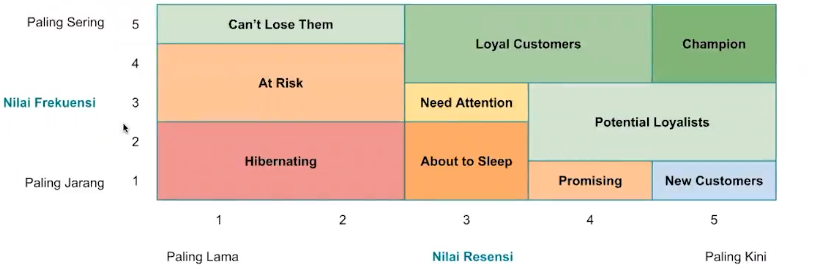

In [ ]:
#membuat nama segmen tiap cohort
df_user["segment"] = np.select(
    [(df_user["score_recency"]==5) & (df_user["score_freq"]>=4),
     (df_user["score_recency"].between(3, 4)) & (df_user["score_freq"]>=4),
     (df_user["score_recency"]>=4) & (df_user["score_freq"].between(2, 3)),
     (df_user["score_recency"]<=2) & (df_user["score_freq"]==5),
     (df_user["score_recency"]==3) & (df_user["score_freq"]==3),
     (df_user["score_recency"]==5) & (df_user["score_freq"]==1),
     (df_user["score_recency"]==4) & (df_user["score_freq"]==1),
     (df_user["score_recency"]<=2) & (df_user["score_freq"].between(3, 4)),
     (df_user["score_recency"]==3) & (df_user["score_freq"]<=2),
     (df_user["score_recency"]<=2) & (df_user["score_freq"]<=2)],
    ["01-Champion", "02-Loyal Customer", "03-Potential Loyalists", "O4- Cn't Lose Them"
    , "05-Need Attention", "06-New Customer", "07-Promising", "08-At Risk",
     "09-About To Sleep", "10-Hibernating"]
)
df_user

,customer_id,order_cnt,max_order_date,total_order_value,last_order,score_recency,score_freq,score_moneter,segment
0,12346.0,5,2010-10-04,602.40,80,2,4,3,08-At Risk
1,12608.0,1,2010-10-31,415.79,53,3,1,2,09-About To Sleep
2,12745.0,2,2010-08-10,723.85,135,2,2,3,10-Hibernating
3,12746.0,2,2010-06-30,266.35,176,1,2,2,10-Hibernating
4,12747.0,19,2010-12-13,4094.79,10,5,5,5,01-Champion
...,...,...,...,...,...,...,...,...,...
3884,18283.0,6,2010-11-22,641.77,31,4,4,3,02-Loyal Customer
3885,18284.0,2,2010-10-06,486.68,78,2,2,3,10-Hibernating
3886,18285.0,1,2010-02-17,427.00,309,1,1,2,10-Hibernating
3887,18286.0,2,2010-08-20,941.48,125,2,2,4,10-Hibernating


In [ ]:
#membuat summary untuk poin sebelumnya
summ = pd.pivot_table(df_user, index="segment",
               values = ["customer_id", "last_order", "order_cnt", "total_order_value"],
               aggfunc = {"customer_id" : pd.Series.nunique,
                          "last_order" : [np.mean, np.median],
                          "order_cnt" : [np.mean, np.median],
                          "total_order_value" : [np.mean, np.median]}
               )
summ ["pct_unique"] = (summ["customer_id"]/summ["customer_id"].sum()*100).round(1)
summ

<ipython-input-31-4597d5dd8dc2>:2: FutureWarning: The provided callable <function mean at 0x7fe4df604e00> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  summ = pd.pivot_table(df_user, index="segment",
<ipython-input-31-4597d5dd8dc2>:2: FutureWarning: The provided callable <function median at 0x7fe4dc33d4e0> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  summ = pd.pivot_table(df_user, index="segment",


customer_id  last_order         order_cnt         \
                           nunique        mean median       mean median   
segment                                                                   
01-Champion                    550   10.618182    9.5  15.467273   10.0   
02-Loyal Customer              546   40.864469   37.0   8.767399    7.0   
03-Potential Loyalists         523   23.573614   24.0   2.829828    3.0   
05-Need Attention              176   58.613636   59.0   3.397727    3.0   
06-New Customer                 50   14.220000   16.0   1.000000    1.0   
07-Promising                   142   32.760563   34.0   1.000000    1.0   
08-At Risk                     426  140.455399  120.0   4.136150    4.0   
09-About To Sleep              352   58.735795   58.0   1.417614    1.0   
10-Hibernating                1060  196.837736  199.0   1.313208    1.0   
O4- Cn't Lose Them              64  121.984375  112.5  11.375000    9.5   

                       total_order_value           pct_unique  
                                    mean    median             
segment                                                        
01-Champion                  5003.674245  2775.525       14.1  
02-Loyal Customer            2622.817826  1946.850       14.0  
03-Potential Loyalists        766.769828   622.070       13.4  
05-Need Attention             989.232676   826.370        4.5  
06-New Customer               244.689000   193.675        1.3  
07-Promising                  287.800282   238.440        3.7  
08-At Risk                   1153.825683   875.430       11.0  
09-About To Sleep             448.229688   334.755        9.1  
10-Hibernating                343.083842   257.005       27.3  
O4- Cn't Lose Them           2839.948125  2268.405        1.6

# Analisis User Segmentation



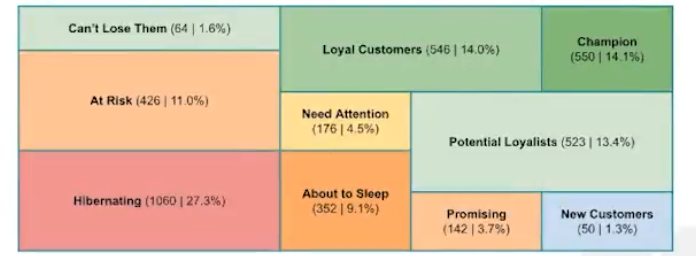

1. Pengguna paling banyak berada pada segment hibernation sebesar (27.3%), diposisi kedua pada segment champion sebesar (14.1%), dan posisi ketiga pada segment loyal customer sebesar (14%).

2. Mengadakan program atau promo khusus yang berfokus pada urgensi bertransaksi untuk loyal customer (14%), untuk membuat mereka kembali melakukan transkasi sehinggan bisa mencapai segment champion.

3. Program Khusus untuk fokus ke pada customer segment potential loyalist, karena mereka lebih sering melakukan transaksi (baru melakukan transaksi dibandingkan loyal cust), sehingga bisa mencapai segment champion

4. Dan untuk segment hibernating dapat dibuat program khusus juga untuk membuat mereka kembali melakukan transaksi meskipun belum terlalu sering sehingga customer pada segment tsb bisa naik ke segment new cust atau bisa ke potential loyalist